# Importing the data and creating the data loaders

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
# importing libraries

import glob
import sys
from zipfile import ZipFile 
import concurrent.futures
import gc
from time import time
import cv2

sys.path.insert(0,'../src/')

import PIL as pil

import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from tqdm import tqdm
import urllib.request
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: emadonev (emadonev-xv-gimnazija) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
def clear_gpu_memory(debug:bool=True):
    """
    Clear GPU memory on all devices.
    Optinonally print the memory before and after clearing.

    Args:
        debug (bool, optional): Print memory before and after clearing. Defaults to False.
    """
    if debug:
        print("GPU memory before clearing.")
        print(f"Allocated: {torch.cuda.memory_allocated() :_}")
        print(f"Reserved: {torch.cuda.memory_reserved() :_}")
    
    # Free up memory
    gc.collect()

    # Clear CUDA memory cache
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    print("GPU memory has been cleared.")

    if debug:
        print("GPU memory after clearing.")
        print(f"Allocated: {torch.cuda.memory_allocated() :_}")
        print(f"Reserved: {torch.cuda.memory_reserved() :_}")

In [5]:
clear_gpu_memory()

GPU memory before clearing.
Allocated: 0
Reserved: 0
GPU memory has been cleared.
GPU memory after clearing.
Allocated: 0
Reserved: 0


In [6]:
from data_processing import *
from cvt import *
from model_train import *

---

In [ ]:
url = "https://zenodo.org/records/3565489/files/images_gz2.zip?download=1"
urllib.request.urlretrieve(url, "../input/images_gz2.zip")

In [7]:
with ZipFile('../input/images_gz2.zip', 'r') as zip_ref:
    zip_ref.extractall(path='../input/images_gz2/')

---

In [7]:
reference_images = pd.read_csv('../input/filename_mapping.csv')

main_catalogue = pd.read_csv('../input/gz2_classes.csv')

In [8]:
reference_images.head()

,objid,sample,asset_id
0,587722981736120347,original,1
1,587722981736579107,original,2
2,587722981741363294,original,3
3,587722981741363323,original,4
4,587722981741559888,original,5


In [9]:
main_catalogue.head()

,specobjid,dr8objid,dr7objid,ra,dec,rastring,decstring,sample,gz2class,total_classifications,...,t11_arms_number_a36_more_than_4_fraction,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag
0,1.802675e+18,NaN,588017703996096547,160.99040,11.703790,10:43:57.70,+11:42:13.6,original,SBb?t,44,...,0.225,0.225,0.225,0,10,10.0,0.250,0.250,0.250,0
1,1.992984e+18,NaN,587738569780428805,192.41083,15.164207,12:49:38.60,+15:09:51.1,original,Ser,45,...,0.000,0.000,0.000,0,0,0.0,0.000,0.000,0.000,0
2,1.489569e+18,NaN,587735695913320507,210.80220,54.348953,14:03:12.53,+54:20:56.2,original,Sc+t,46,...,0.651,0.651,0.651,0,3,3.0,0.070,0.070,0.070,0
3,2.924084e+18,1.237668e+18,587742775634624545,185.30342,18.382704,12:21:12.82,+18:22:57.7,original,SBc(r),45,...,0.071,0.071,0.071,0,6,6.0,0.429,0.429,0.429,0
4,1.387165e+18,1.237658e+18,587732769983889439,187.36679,8.749928,12:29:28.03,+08:44:59.7,extra,Ser,49,...,0.000,0.000,0.000,0,1,1.0,1.000,1.000,1.000,0


In [10]:
# create modified main catalogue
model_01_catalogue = pd.DataFrame()
model_01_catalogue['dr7ID'] = main_catalogue['dr7objid']
model_01_catalogue['class'] = main_catalogue['gz2class']
print(model_01_catalogue.shape)
model_01_catalogue.head()

(243500, 2)


,dr7ID,class
0,588017703996096547,SBb?t
1,587738569780428805,Ser
2,587735695913320507,Sc+t
3,587742775634624545,SBc(r)
4,587732769983889439,Ser


In [ ]:
model_01_catalogue.drop(model_01_catalogue[model_01_catalogue['class'] == 'A'].index, inplace=True)
model_01_catalogue.shape

(243253, 2)

In [ ]:
# connecting each class with the corresponding asset_id
model_01_catalogue = model_01_catalogue.merge(
    reference_images[['objid', 'asset_id']], 
    left_on='dr7ID', 
    right_on='objid', 
    how='left'
).drop(columns=['objid'])  # Drop extra 'objid' column after merging
model_01_catalogue = model_01_catalogue.sort_values(by=['asset_id']).reset_index(drop=True)

model_01_catalogue['class'] = model_01_catalogue['class'].apply(lambda x: x.replace('(', '').replace(')', '').ljust(6, '0'))
model_01_catalogue.head()

,dr7ID,class,asset_id
0,587722981741363294,Ei0000,3
1,587722981741363323,Sc0000,4
2,587722981741559888,Er0000,5
3,587722981741625481,Er0000,6
4,587722981741625484,Ei0000,7


In [13]:
# creating a label diagram table
label_diagram = pd.DataFrame(columns=['r1', 'r2', 'r3', 'r4', 'r5'])
label_diagram['asset_id'] = model_01_catalogue['asset_id']
label_diagram['r1'] = model_01_catalogue['class'].apply(choose_class1)
label_diagram['r2'] = model_01_catalogue['class'].apply(choose_class2)
label_diagram['r3'] = model_01_catalogue['class'].apply(choose_class3)
label_diagram['r4'] = model_01_catalogue['class'].apply(choose_class4)
label_diagram['r5'] = model_01_catalogue['class'].apply(choose_class5)
label_diagram.head()

,r1,r2,r3,r4,r5,asset_id
0,E,is,0,0,0,3
1,S,c,0,0,0,4
2,E,rs,0,0,0,5
3,E,rs,0,0,0,6
4,E,is,0,0,0,7


In [ ]:
label_diagram[label_diagram["asset_id"]==172444]

,r1,r2,r3,r4,r5,asset_id
148289,S,b,?,ts,0,172444


In [15]:
label_diagram['r2'].value_counts()

r2
c     58314
is    50272
b     48842
rs    47458
br    15241
bn     8445
d      6429
cs     5785
a      2149
bb      318
Name: count, dtype: int64

In [14]:
label_diagram.to_csv("../input/label_diagram.csv", index=False)

In [16]:
imgs_path = '../input/images_gz2/images/'
W, H, C = 224, 224, 4

In [17]:
file_list = glob.glob(os.path.join(imgs_path, '*.jpg'))
file_list = sorted(file_list)

In [16]:
file_list = file_list[:5]

In [26]:
runs = {f: () for f in file_list}

for i in label_diagram.columns:
    if i == 'asset_id':
        continue
    # Create a mapping from asset_id to the current label value
    label_map = label_diagram.set_index('asset_id')[i].to_dict()
    # For each file, append the label value to the tuple already stored (or create a new tuple)
    for f in file_list:
        asset_id = int(f.split('/')[-1].split('.')[0]) # select the asset_id
        label_val = label_map.get(asset_id, None) # get the label value
        runs[f] = runs.get(f, ()) + (label_val,) # connect the filename and the label value

In [29]:
run = [(f, runs[f][0]) for f in file_list]
images_orig = [x[0] for x in run]
labels_orig = [x[1] for x in run]
print(len(images_orig), len(labels_orig))
print(images_orig[:2])
print(labels_orig[:2])

5 5
['../input/images_gz2/images/100.jpg', '../input/images_gz2/images/1000.jpg']
['S', 'E']


In [32]:
img_sub, im, labels_sub, l = train_test_split(images_orig, labels_orig, train_size=3, random_state=42, shuffle=True)

In [33]:
img_sub

['../input/images_gz2/images/10000.jpg',
 '../input/images_gz2/images/100.jpg',
 '../input/images_gz2/images/100000.jpg']

In [34]:
labels_sub

['E', 'S', 'Se']

In [35]:
file_list = img_sub

---

In [26]:
run1 = [(f, runs[f][0]) for f in file_list]
print(run1)

[('../input/images_gz2/images/100.jpg', 'S'), ('../input/images_gz2/images/1000.jpg', 'E'), ('../input/images_gz2/images/10000.jpg', 'E'), ('../input/images_gz2/images/100000.jpg', 'Se'), ('../input/images_gz2/images/100001.jpg', 'E')]


In [ ]:
label_diagram['r1'].value_counts()

r1
E     103515
S      94332
Se     24004
SB     21402
Name: count, dtype: int64

In [18]:
file_list = create_file_list(imgs_path, label_diagram)
print('file list loaded')
n = 1000/len(file_list)
img_sub, labels_sub = data_setup(file_list, label_diagram, n)
print("splitting data")
train, valid, test = split_data(img_sub, labels_sub)

file list loaded
243253 243253
['../input/images_gz2/images/100.jpg', '../input/images_gz2/images/1000.jpg']
['S', 'E']
splitting data


In [20]:
train_dl, valid_dl, test_dl, y_train, y_valid, y_test = create_data_loaders(train, valid, test, label_diagram, 0, 32, aux_train=None, aux_valid=None, aux_test=None)

KeyboardInterrupt: 

In [ ]:
y_train

In [54]:
def visualize_data(loader, num):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    print("Batch size:", images.size(), labels.size())

    for i in range(num):
        img = images[i][:3, :, :].permute(1, 2, 0).numpy()

        label = labels[i].item()
        plt.figure(figsize=(3,3))
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

Batch size: torch.Size([32, 4, 224, 224]) torch.Size([32])


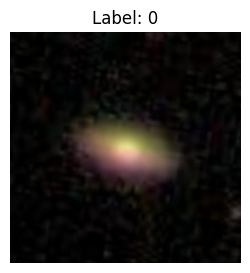

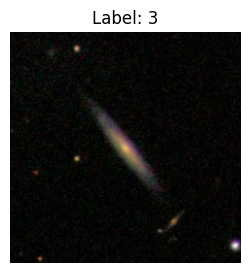

In [56]:
visualize_data(train_dl, 2)

---

In [31]:
file_list = glob.glob(os.path.join(imgs_path, '*.jpg'))
file_list = sorted(file_list)

# select files whose asset_id is the same as the one in the label_diagram
file_list = [f for f in file_list if int(f.split('/')[-1].split('.')[0]) in label_diagram['asset_id'].values]
len(file_list)

243253

In [36]:
len(file_list)

243253

In [38]:
class_mapping = {x : i for i, x in enumerate(sorted(label_diagram['r1'].unique()))}
n = 0.0411

if __name__ == '__main__':
    gmorph_d = galaxy_img_dataset(file_list, label_diagram, label_mapping='r1', class_mapping=class_mapping)
    images = [x[0] for x in gmorph_d]
    labels = [x[1] for x in gmorph_d]

    img_sub, im, labels_sub, l = train_test_split(images, labels, train_size=n, random_state=42, stratify=labels, shuffle=True)
    print(len(img_sub), len(labels_sub))

    x = np.array(img_sub)
    y = np.array(labels_sub)

    bs = 32
    # ---------
    x_train, x_rem, y_train, y_rem = train_test_split(x,y, train_size=0.7, random_state=42, stratify=y, shuffle=True)

    x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.34, random_state=42, stratify=y_rem, shuffle=True)

    x_train, y_train, x_valid, y_valid, x_test, y_test = map(torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test))

    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=16, pin_memory=True)

    valid_ds = TensorDataset(x_valid, y_valid)
    valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=16,pin_memory=True)

    test_ds = TensorDataset(x_test, y_test)
    test_dl = DataLoader(test_ds, batch_size=bs, shuffle=True, num_workers=16,pin_memory=True)


: 

---

In [24]:
import gc

In [25]:
gc.collect()

674

In [27]:
epochs = 1
lr = 0.001
tmax = epochs
gmavailable() else 'cpu'
batch_size = 32
embed_size = 64available() else 'cpu'
batch_size = 32
embed_size = 64

---

In [29]:
gmorph_model = CvT(embed_size, len(class_mapping))
optimizer = torch.optim.AdamW(gmorph_model.parameters(), lr=lr, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, tmax, eta_min=1e-6)
loss_func = nn.CrossEntropyLoss()

results, results_class, train_pred, train_true, train_probs, valid_pred, valid_true, valid_probs = train_model(epochs, gmorph_model, train_dl, valid_dl, loss_func, optimizer, scheduler, device, save_name=f'test_shapes')

Run name: test_shapes
image shape torch.Size([32, 4, 224, 224])
aux layer selected torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 64])
conv embedding shape torch.Size([32, 3136, 64])
passed through attention torch.Size([32, 3136, 64])
final out torch.Size([32, 64, 56, 56])
image shape torch.Size([32, 64, 56, 56])
conv embedding shape torch.Size([32, 784, 192])
passed through attention torch.Size([32, 784, 192])
final out torch.Size([32, 192, 28, 28])
image shape torch.Size([32, 192, 28, 28])
conv embedding shape torch.Size([32, 196, 384])
cls_token provided torch.Size([32, 197, 384])
passed through attention torch.Size([32, 197, 384])
image shape torch.Size([32, 4, 224, 224])
aux layer selected torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 64])
conv embedding shape torch.Size([32, 3136, 64])
passed through attention torch.Size([32, 3136, 64])
final out torch.Size([32, 64, 56, 56])
image shape torch.Size([32, 64, 56, 56])
conv embedding shape torch.Size([32, 784, 192])
passed throu

train_F1,▁
train_acc,▁
train_loss,▁
train_precision,▁
train_recall,▁
valid_F1,▁
valid_acc,▁
valid_loss,▁
valid_precision,▁
valid_recall,▁
train_F1,0.2012


Training time = 0.0283196489016215 minutes


In [17]:
results_runs = np.load('../output/results_runs.npy', allow_pickle=True)
results_runs

array([{0: [1.7587795148577008, 0.37857142857142856, 0.26807742038899673, 0.2605936706322916, 0.26099824817021317, 1.2618426786461456, 0.38578680203045684, 0.09644670050761421, 0.25, 0.1391941391941392]},
       {0: [1.6909119851248604, 0.37285714285714283, 0.24881174590742944, 0.23502652519893902, 0.23818752614748273, 1.06809292680721, 0.5076142131979695, 0.12971449641803623, 0.25, 0.1699706986539694]}],
      dtype=object)

In [20]:
results_runs[0]

{0: [1.7587795148577008,
  0.37857142857142856,
  0.26807742038899673,
  0.2605936706322916,
  0.26099824817021317,
  1.2618426786461456,
  0.38578680203045684,
  0.09644670050761421,
  0.25,
  0.1391941391941392]}

In [21]:
results_runs_class = np.load('../output/results_runs_class.npy', allow_pickle=True)
results_runs_class

array([{0: [[[0.00313568115234375, 0.0009436607360839844, 0.9951171875, 0.0008263587951660156], [0.033599853515625, 0.00116729736328125, 0.95849609375, 0.00678253173828125], [2.849102020263672e-05, 0.00011479854583740234, 0.99951171875, 0.00012242794036865234], [0.0193634033203125, 0.00833892822265625, 0.93603515625, 0.036224365234375], [0.0013551712036132812, 0.0008563995361328125, 0.99755859375, 0.00014007091522216797], [0.0019283294677734375, 0.00467681884765625, 0.990234375, 0.003063201904296875], [0.0035533905029296875, 0.0009331703186035156, 0.9921875, 0.003536224365234375], [0.00220489501953125, 0.0008978843688964844, 0.99609375, 0.0007443428039550781], [8.231401443481445e-05, 0.0005593299865722656, 0.99755859375, 0.001850128173828125], [0.0005517005920410156, 0.0005593299865722656, 0.99755859375, 0.0015316009521484375], [0.0012331008911132812, 0.0005745887756347656, 0.97802734375, 0.020233154296875], [0.00010901689529418945, 4.5359134674072266e-05, 0.99560546875, 0.004470825195

In [23]:
results_runs_class[1]

{0: [[[0.04644775390625,
    0.030914306640625,
    0.008575439453125,
    0.0110015869140625,
    0.328857421875,
    0.381591796875,
    0.0035343170166015625,
    0.007720947265625,
    0.16064453125,
    0.020721435546875],
   [0.081298828125,
    0.0102386474609375,
    0.003223419189453125,
    0.051544189453125,
    0.053466796875,
    0.4296875,
    0.040435791015625,
    0.01052093505859375,
    0.07232666015625,
    0.2471923828125],
   [0.0015554428100585938,
    0.037933349609375,
    0.002620697021484375,
    0.0015401840209960938,
    0.517578125,
    0.32275390625,
    0.00031256675720214844,
    0.0033855438232421875,
    0.0966796875,
    0.01568603515625],
   [0.034942626953125,
    0.0153350830078125,
    0.003688812255859375,
    0.0171356201171875,
    0.00981903076171875,
    0.04925537109375,
    4.798173904418945e-05,
    0.10308837890625,
    0.5380859375,
    0.2286376953125],
   [0.0024013519287109375,
    0.005527496337890625,
    0.0006275177001953125,
    

In [24]:
outputs_test = np.load('../output/outputs_test.npy', allow_pickle=True)
outputs_test

array([[1, 1, 1, 1, 1, 1, 1],
       [5, 5, 8, 8, 8, 8, 8]])

In [25]:
labels_test = np.load('../output/labels_test.npy', allow_pickle=True)
labels_test

array([[2, 0, 3, 0, 2, 1, 0],
       [5, 1, 9, 9, 9, 9, 9]])